# "Distinguish Your Own Digits "
> "Implementing a classifier that distinguishes between the number 3 and number 8"

- toc: true
- branch: master
- badges: true
- comments: true
- author: Jagriti Goswami
- categories: [fastpages, jupyter]

In [1]:
#hide

%load_ext autoreload
%autoreload 2

In [2]:
#hide

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#hide

!pip install mnist

## Preparing the Data

In [4]:
#hide
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
#hide

train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
#hide

test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

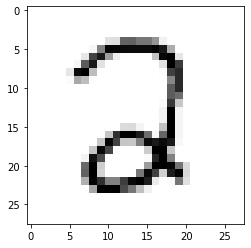

In [41]:
image_index = 7776 
plt.imshow(train_images[image_index], cmap='Greys');

## Filtering data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pixel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

Setting up the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
#hide

X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [15]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [16]:
#hide

from kudzu.data import Data, Sampler, Dataloader
from kudzu.callbacks import Callback, ClfCallback
from kudzu.loss import BCE
from kudzu.layer import Affine, Relu, Sigmoid
from kudzu.model import Model
from kudzu.optim import GD
from kudzu.train import Learner

In [17]:
data = Data(X_train, y_train)
loss = BCE() #Binary Cross Entropy Loss function

#### Initialisations

In [18]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 200
config.bs = 50

In [19]:
opt = GD(config.lr)
sampler = Sampler(data, config.bs, shuffle=True)
dl = Dataloader(data, sampler)

#### Putting the layers together

In [42]:
layers = [Affine("first", 784, 100), Relu("relu"), Affine("second", 100, 100), Relu("relu"), Affine("third", 100, 2), Affine("final", 2, 1),Sigmoid("sigmoid")]
model = Model(layers)

## Training the model

#### Neural Network Implementation

In [21]:
learner = Learner(loss, model, opt, config.num_epochs)
acc = ClfCallback(learner, config.bs, X_train, y_train, X_test, y_test)
learner.set_callbacks([acc])

In [40]:
learner.train_loop(dl)

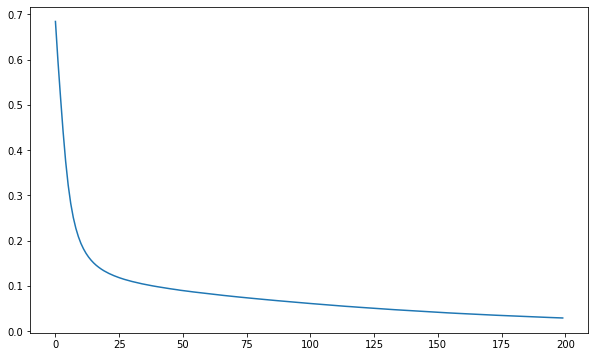

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(acc.losses);

#### Logistic Regression Implementation

In [43]:
LR_layers = [Affine("logits", 784, 1), Sigmoid("sigmoid")];

In [25]:
LR_model = Model(LR_layers)

In [26]:
LR_learner = Learner(loss, LR_model, opt, config.num_epochs)
LR_acc = ClfCallback(LR_learner, config.bs, X_train, y_train, X_test, y_test)
LR_learner.set_callbacks([LR_acc])

In [39]:
LR_learner.train_loop(dl) 

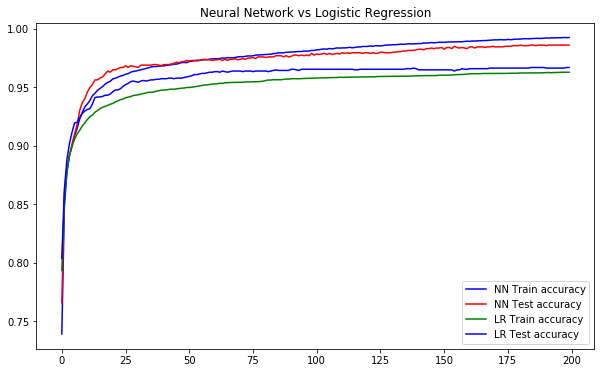

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(acc.accuracies,'b-', label = "NN Train accuracy")
plt.plot(acc.test_accuracies,'r-', label = "NN Test accuracy")
plt.plot(LR_acc.accuracies,'g-', label = "LR Train accuracy")
plt.plot(LR_acc.test_accuracies,'b-', label = "LR Test accuracy")
plt.title("Neural Network vs Logistic Regression")
plt.legend();

It can be seen from the above figure that while for the Neural Network model is already overfitting, the validation accuracy has dipped below the training accuracy and they are diverging, its not the case for Linear Regression

## Confusion Matrix

In [29]:
probs = model(X_test)
predictions = 1*(probs >= 0.5)

In [30]:
#hide

from sklearn.metrics import confusion_matrix

In [31]:
c_matrix = confusion_matrix(y_test, predictions)
print(f"Confusion Matrix: {c_matrix}")
print(f"False positive: {c_matrix[0][1]}")
print(f"False negative: {c_matrix[1][0]}")
m_classify = c_matrix[0][1] + c_matrix[1][0]
print(f"Number of misclassifications: {m_classify}")

Confusion Matrix: [[962  12]
 [ 16 994]]
False positive: 12
False negative: 16
Number of misclassifications: 28


Our accuracy is quite high!!

## Plotting data in the embedding space

In [32]:
def get_embedding(input):
    upto_embed = model.layers[:-2]
    for l in upto_embed:
        input = l(input)
    return input

In [33]:
ES = get_embedding(X_test)

In [34]:
#hide

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

In [35]:
X, y = make_classification(200, 2, 2, 0, weights=[.5, .5], random_state=15)
clf = LogisticRegression().fit(X[:100], y[:100])

In [36]:
xgrid = np.linspace(-10,10,100)
ygrid = np.linspace(-10,10,100)
xx, yy = np.meshgrid(xgrid,ygrid)
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)

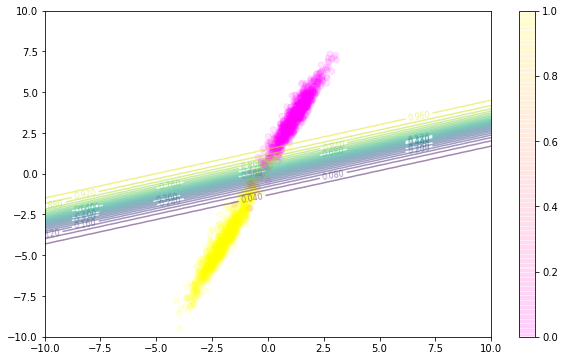

In [37]:
plt.figure(figsize=(10, 6))
contour = plt.contour(xx, yy, probs, 25,vmin=0, vmax=1, alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)
plt.scatter(ES[:,0], ES[:,1], c = y_test.ravel(), cmap = "spring", alpha=0.1)
plt.colorbar();

## Actual vs Prediction

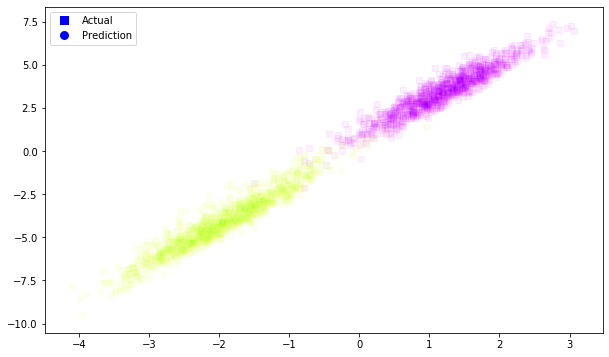

In [38]:
from matplotlib.lines import Line2D
plt.figure(figsize=(10, 6))
plt.scatter(ES[:,0], ES[:,1], c = y_test.ravel(), marker = "s", cmap = "spring", alpha=0.05)
plt.scatter(ES[:,0], ES[:,1], c = predictions.ravel(),marker = "o", cmap = "winter", alpha=0.01)
legend_elements = [Line2D([0], [0], marker='s', color='w', label='Actual',markerfacecolor='b', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Prediction',markerfacecolor='b', markersize=10)]
plt.legend(handles=legend_elements);